In [1]:
%load_ext autoreload
%autoreload 2 

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal as mvn
from hetgpy import homGP, hetGP
import pandas as pd
import yaml
from typing import Dict
import json
import time
from collections import Counter, defaultdict

from helpers import *

from eqsql import worker_pool, db_tools, cfg
from eqsql.task_queues import local_queue

#### Setup EMEWS DB

In [3]:

config_file = "./algo_cfg.yaml"
params = cfg.parse_yaml_cfg(config_file)

exp_id = 1
# start database
#db_tools.stop_db(params['db_path'])
db_tools.start_db(params['db_path'], pg_bin_path=params['pg_bin_path'])
db_started = True

# start local task queue
task_queue = local_queue.init_task_queue(params['db_host'], params['db_user'],
                                            port=None, db_name=params['db_name'])

# check if the input and output queues are empty,
# if not, then exit with a warning.
if not task_queue.are_queues_empty():
    print("WARNING: db input / output queues are not empty. Aborting run", flush=True)
    task_queue.clear_queues()


# start worker pool
pool_params = worker_pool.cfg_file_to_dict(params['pool_cfg_file'])
pool = worker_pool.start_local_pool(params['worker_pool_id'], params['pool_launch_script'],
                                    exp_id, pool_params)
task_type = params['task_type']

Checking for pg_ctl ...
/Users/abbystevens/miniconda3/envs/emews-py3.10/bin/pg_ctl

Failure Stopping Database: database is not running.
Checking for pg_ctl ...
/Users/abbystevens/miniconda3/envs/emews-py3.10/bin/pg_ctl


Starting database with log:/Users/abbystevens/Documents/db/emews_db/db.log
Database server started


#### Generate grid and initial design

In [4]:
# set up grid
xx = np.linspace(0, 1, 30)
Xgrid = np.array(np.meshgrid(xx, xx)).T.reshape(-1, 2)
Xgrid_native = to_native(Xgrid, lb=np.array([0.1, 1]), ub=np.array([1, 3]))

# generate some seeds
seeds = np.random.choice(1000, 100, replace=False)

# budget
budget = 50
nts = 10 #number of new points per thompson sample

# initialize 
init_ids = [217, 233, 465, 697, 713]
init_reps = 3
init_ids = {x:init_reps for x in init_ids}
budget -= len(init_ids)*init_reps

init_seeds = seeds[:init_reps]
id_counter = Counter()

X, Xnative = generate_inputs(Xgrid, init_ids, id_counter, seeds)

#### Submit initial payload to run simulations on initially selected points

In [5]:
# run initial simulations
payloads = list(map(lambda a: json.dumps(list(a)), Xnative))
_, fts = task_queue.submit_tasks(exp_id, task_type, payloads)

sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
Y = np.array([json.loads(ft.result()[1]) for ft in sorted_fts])

# normalizing Y for numerical stability
Y = np.log(Y)
ymean, ystd = Y.mean(), Y.std()
Y = (Y-ymean)/ystd

#### Fit GP on initial design

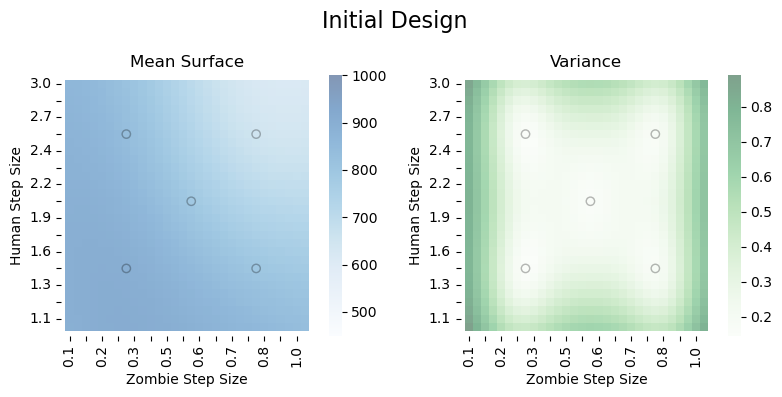

In [7]:
gp = hetGP()
gp.mle(X, Y, covtype='Matern5_2', upper=np.array([100, 100]), init={'g_bounds':[1e-6, .1]})

#plot_gp_mean(gp, Xgrid, X, ymean, ystd, title='Initial design')
plot_gp(gp, Xgrid, X, ymean, ystd, title='Initial Design')

In [8]:
gp.summary()

N =  15  n =  5  d =  2 

Matern5_2  covariance lengthscale values of the main process:  [0.5882297 1.0787115] 

Variance/scale hyperparameter:  3.4670351191122575 

Summary of Lambda values: 

{'Min': '1.92e-02', '1st Qu.': '1.97e-02', 'Median': '2.40e-02', '3rd Qu.': '2.85e-02', 'Max': '2.88e-02'}
Estimated constant trend value:  0.018293749975188827 

Matern5_2  covariance lengthscale values of the log-noise process:  [0.59063631 1.08312479] 

Nugget of the log-noise process:  0.8635577642481364 

Estimated constant trend value of the log-noise process:  -3.7641580858517125 

MLE optimization: 
 Log-likelihood =  -11.364109530560007 ; Nb of evaluations (obj, gradient) by L-BFGS-B:  84 ; message:  ABNORMAL_TERMINATION_IN_LNSRCH 



#### Until the budget is exhausted, iteratively find new parameters to evaluate using Thompson Sampling

Covariance matrix is not positive semidefinite. Clip negative eigenvalues.
After iteration 1, we found that 975 humans can survive at zombie_step_size = 0.1, human_step_size = 1.0


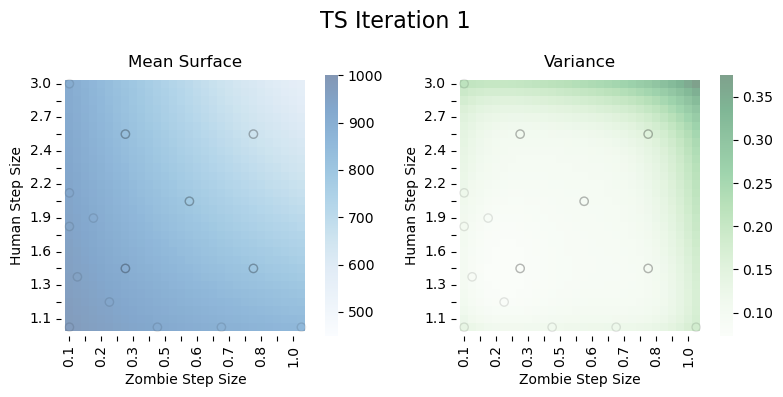

Covariance matrix is not positive semidefinite. Clip negative eigenvalues.
After iteration 2, we found that 988 humans can survive at zombie_step_size = 0.1, human_step_size = 1.0


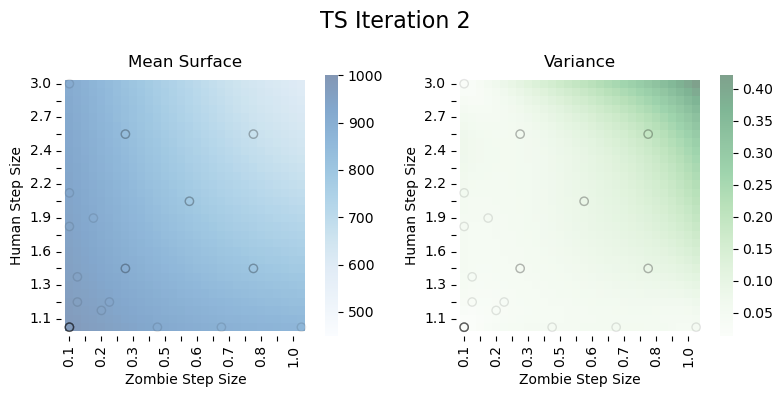

Covariance matrix is not positive semidefinite. Clip negative eigenvalues.
After iteration 3, we found that 988 humans can survive at zombie_step_size = 0.1, human_step_size = 1.0


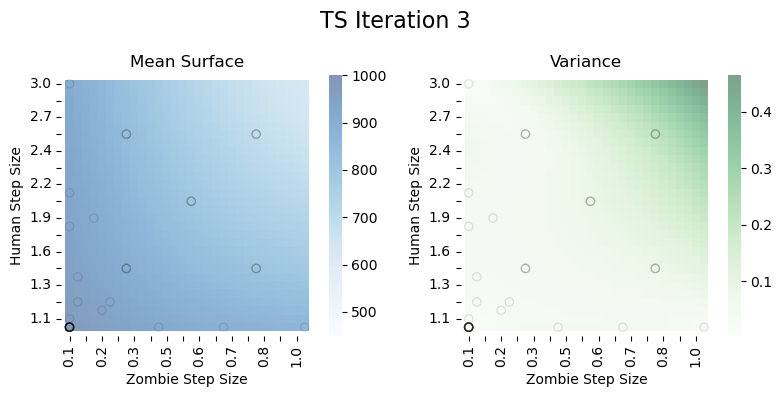

Covariance matrix is not positive semidefinite. Clip negative eigenvalues.
After iteration 4, we found that 988 humans can survive at zombie_step_size = 0.1, human_step_size = 1.0


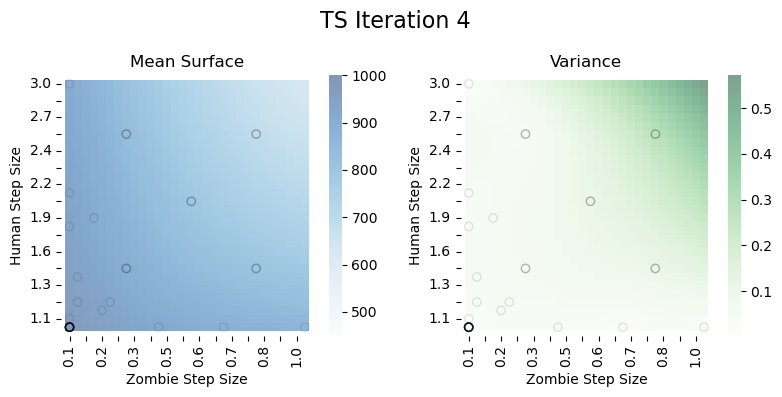

In [9]:
i = 1
while budget > 0:
    # thompson sample for best locations
    best_ids = Counter(TS_npoints_replicates(gp, min(nts,budget), Xgrid))
    budget -= nts
    
    # get new runs and combine
    Xnew, Xnew_native = generate_inputs(Xgrid, best_ids, id_counter, seeds)
    payloads = list(map(lambda a: json.dumps(list(a)), Xnew_native))
    _, fts = task_queue.submit_tasks(exp_id, task_type, payloads)
    sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
    Ynew = np.array([json.loads(ft.result()[1]) for ft in sorted_fts])
    # scale outputs
    Ynew = np.log(Ynew)
    Ynew = (Ynew - ymean)/ystd

    X = np.vstack([X, Xnew])
    Y = np.concatenate([Y, Ynew])

    Xnative = to_native(X, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
    Ynative = Ynative = np.exp(Y*ystd + ymean)
    best_ix = np.argmax(Ynative)
    print(f"After iteration {i}, we found that {round(Ynative[best_ix])} humans can survive at zombie_step_size = {round(Xnative[best_ix, 0],2)}, human_step_size = {Xnative[best_ix, 1]}")
    gp = hetGP()
    gp.mle(X, Y, covtype='Matern5_2', upper=np.array([100, 100]), 
           init={'g_bounds':[1e-6, .1]}, maxit=1000)
    #plot_gp_mean(gp, Xgrid, X, ymean, ystd, title=f'TS Iteration {i}')
    plot_gp(gp, Xgrid, X, ymean, ystd, title=f'TS Iteration {i}')
    #best_ids = Counter(TS_npoints_replicates(gp, min(nts,budget), Xgrid))
    #budget -= nts
    i += 1


#### Close DB

In [10]:
if task_queue is not None:
    task_queue.close()
if pool is not None:
    pool.cancel()
if db_started:
    db_tools.stop_db(params['db_path'])

Checking for pg_ctl ...
/Users/abbystevens/miniconda3/envs/emews-py3.10/bin/pg_ctl


Stopping database server

waiting for server to shut down.... done
server stopped

